In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Define the path to the CSV file
file_path = "../data/hotel_bookings.csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

In [4]:
# Fill missing values for 'children' column with 0
df['children'].fillna(0, inplace=True)

# Fill missing values for 'country' with the mode
df['country'].fillna(df['country'].mode()[0], inplace=True)

# Fill missing values for 'agent' and 'company' with 0
df['agent'].fillna(0, inplace=True)
df['company'].fillna(0, inplace=True)

In [5]:
df.drop(columns=['reservation_status', 'reservation_status_date'], inplace=True)

In [6]:
# List of categorical columns
categorical_columns = ['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment', 
                       'distribution_channel', 'reserved_room_type', 'assigned_room_type', 
                       'deposit_type', 'customer_type', 'arrival_date_year', 
                       'arrival_date_week_number', 'arrival_date_day_of_month', 
                       'company', 'agent']

# Label encode the categorical columns
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [7]:
# Calculate the correlation matrix
corr_matrix = df.corr()
corr_matrix

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
hotel,1.000000,-0.136531,-0.075381,-0.035267,-0.035378,-0.001270,0.001862,0.186596,0.234020,0.013183,...,0.307834,0.072820,-0.159021,0.649010,0.104937,-0.072432,-0.047531,-0.096719,0.218873,0.043390
is_canceled,-0.136531,1.000000,0.293123,0.016660,-0.001491,0.008148,-0.006130,-0.001791,0.024765,0.060017,...,-0.176028,-0.144381,0.468634,-0.046782,-0.081265,0.054186,-0.068140,0.047557,-0.195498,-0.234658
lead_time,-0.075381,0.293123,1.000000,0.040142,0.086228,0.126871,0.002268,0.085671,0.165799,0.119519,...,-0.172219,0.000149,0.375667,-0.011931,-0.085658,0.170084,0.073403,-0.063077,-0.116451,-0.095712
arrival_date_year,-0.035267,0.016660,0.040142,1.000000,-0.251837,-0.540561,-0.000221,0.021497,0.030883,0.029635,...,0.036141,0.030872,-0.064714,0.053847,0.036493,-0.056497,-0.006149,0.197580,-0.013684,0.108531
arrival_date_month,-0.035378,-0.001491,0.086228,-0.251837,1.000000,0.302228,-0.017938,-0.031869,-0.025746,-0.058284,...,-0.038134,-0.017854,0.068173,-0.038831,0.026738,0.048357,0.012029,-0.109004,-0.018589,-0.053047
arrival_date_week_number,-0.001270,0.008148,0.126871,-0.540561,0.302228,1.000000,0.066809,0.018208,0.015558,0.025909,...,-0.005684,0.005508,0.003891,-0.017611,-0.033718,0.022933,-0.028432,0.075791,0.001920,0.026149
arrival_date_day_of_month,0.001862,-0.006130,0.002268,-0.000221,-0.017938,0.066809,1.000000,-0.016354,-0.028174,-0.001566,...,0.011646,0.010613,-0.001358,0.000033,0.003870,0.022728,0.012188,0.030245,0.008683,0.003062
stays_in_weekend_nights,0.186596,-0.001791,0.085671,0.021497,-0.031869,0.018208,-0.016354,1.000000,0.498969,0.091871,...,0.086643,0.063281,-0.111435,0.163781,-0.077817,-0.054151,-0.109220,0.049342,-0.018554,0.072671
stays_in_week_nights,0.234020,0.024765,0.165799,0.030883,-0.025746,0.015558,-0.028174,0.498969,1.000000,0.092976,...,0.100795,0.096209,-0.076788,0.198519,-0.042749,-0.002020,-0.127223,0.065237,-0.024859,0.068192
adults,0.013183,0.060017,0.119519,0.029635,-0.058284,0.025909,-0.001566,0.091871,0.092976,1.000000,...,0.144779,-0.051673,-0.027644,0.024751,-0.161885,-0.008283,-0.101756,0.230641,0.014785,0.122884


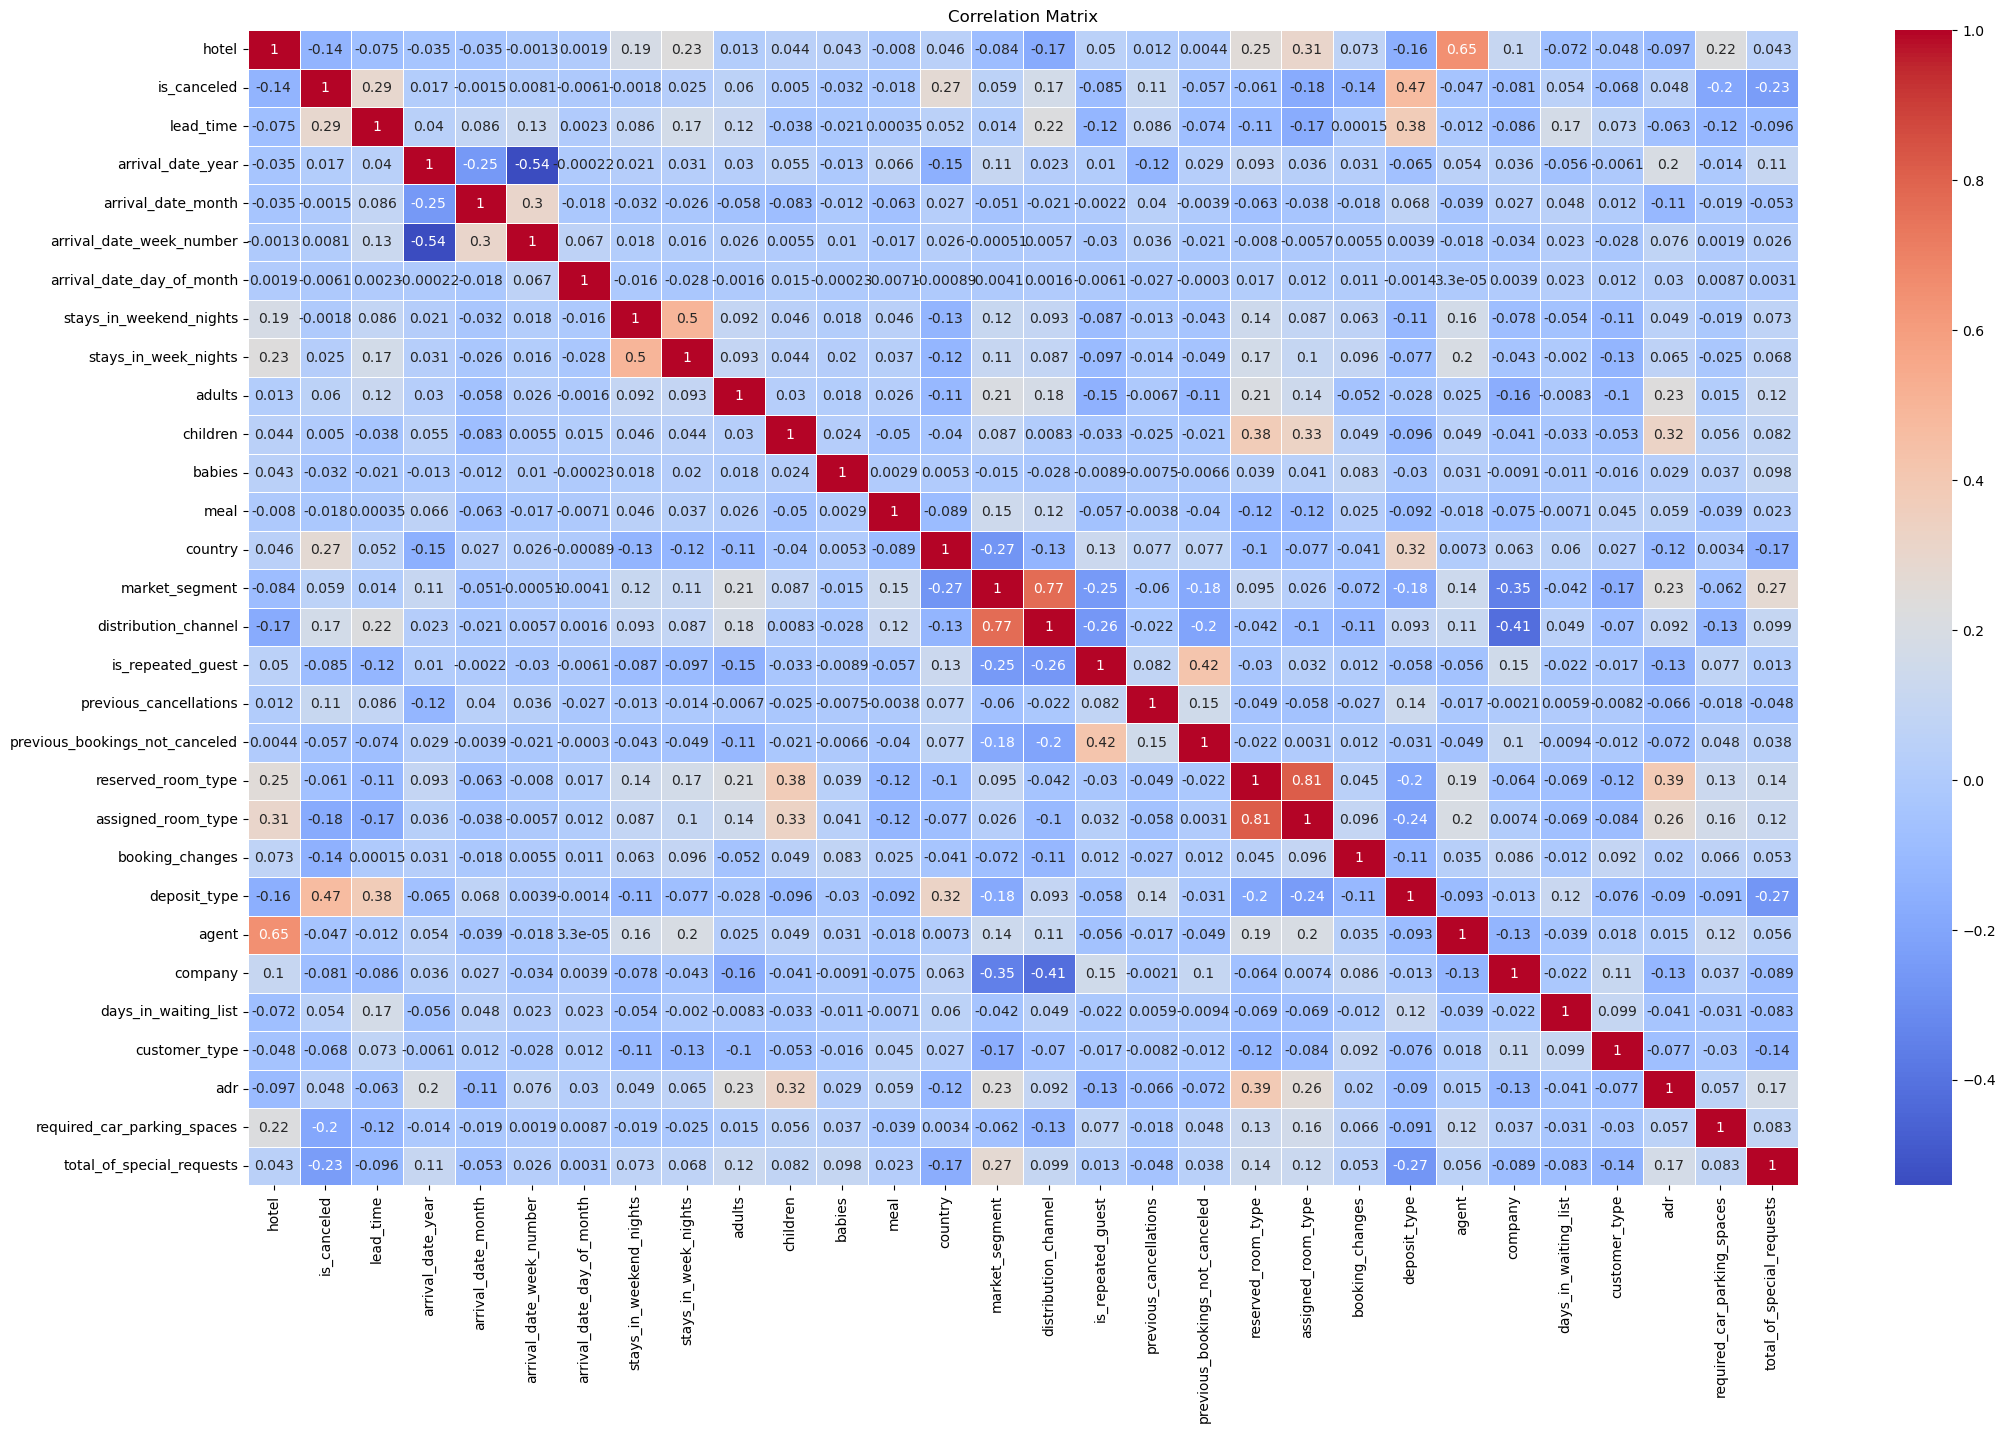

In [8]:
# Plot the correlation matrix
plt.figure(figsize=(25,15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.4)
plt.title('Correlation Matrix')
plt.savefig('CorrelationMatrix.png')  # Save the figure
plt.show()

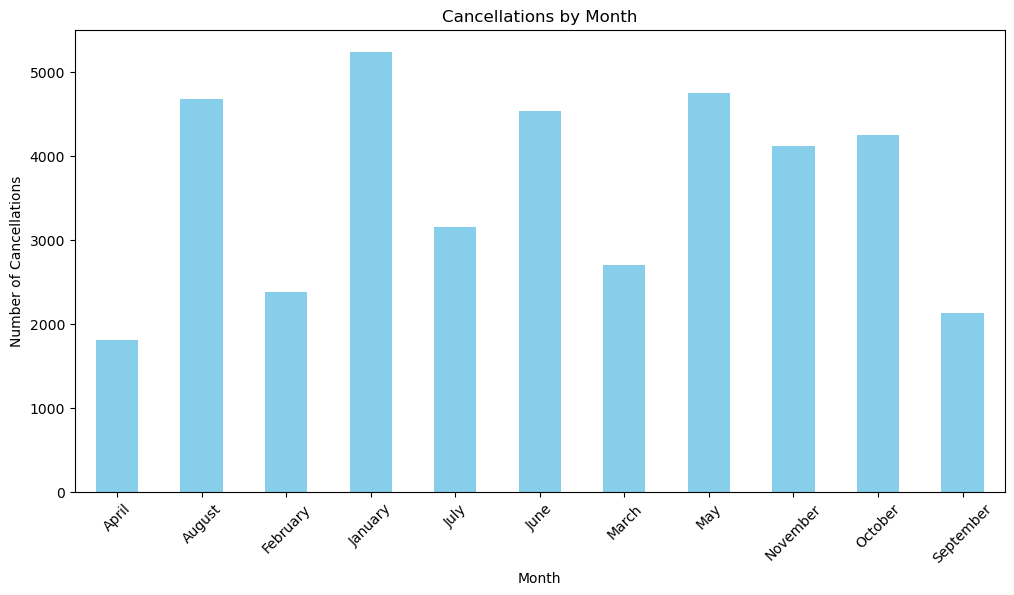

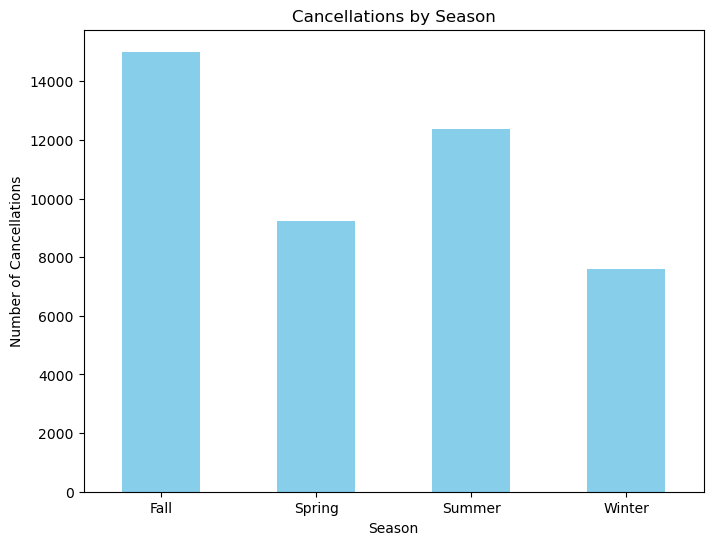

In [9]:
# Convert month numbers to month names for better readability
df['arrival_date_month'] = df['arrival_date_month'].map({
    1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
    7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'
})

# Extract season from the month
def get_season(month):
    if month in ['December', 'January', 'February']:
        return 'Winter'
    elif month in ['March', 'April', 'May']:
        return 'Spring'
    elif month in ['June', 'July', 'August']:
        return 'Summer'
    else:
        return 'Fall'

df['season'] = df['arrival_date_month'].apply(get_season)

# Calculate cancellations by month
cancellations_by_month = df.groupby('arrival_date_month')['is_canceled'].sum()

# Plot cancellations by month
plt.figure(figsize=(12, 6))
cancellations_by_month.plot(kind='bar', color='skyblue')
plt.title('Cancellations by Month')
plt.xlabel('Month')
plt.ylabel('Number of Cancellations')
plt.xticks(rotation=45)
plt.savefig('Cancelation_Month.png') 
plt.show()

# Calculate cancellations by season
cancellations_by_season = df.groupby('season')['is_canceled'].sum()

# Plot cancellations by season
plt.figure(figsize=(8, 6))
cancellations_by_season.plot(kind='bar', color='skyblue')
plt.title('Cancellations by Season')
plt.xlabel('Season')
plt.ylabel('Number of Cancellations')
plt.xticks(rotation=0)
plt.savefig('Cancelation_Season.png') 
plt.show()



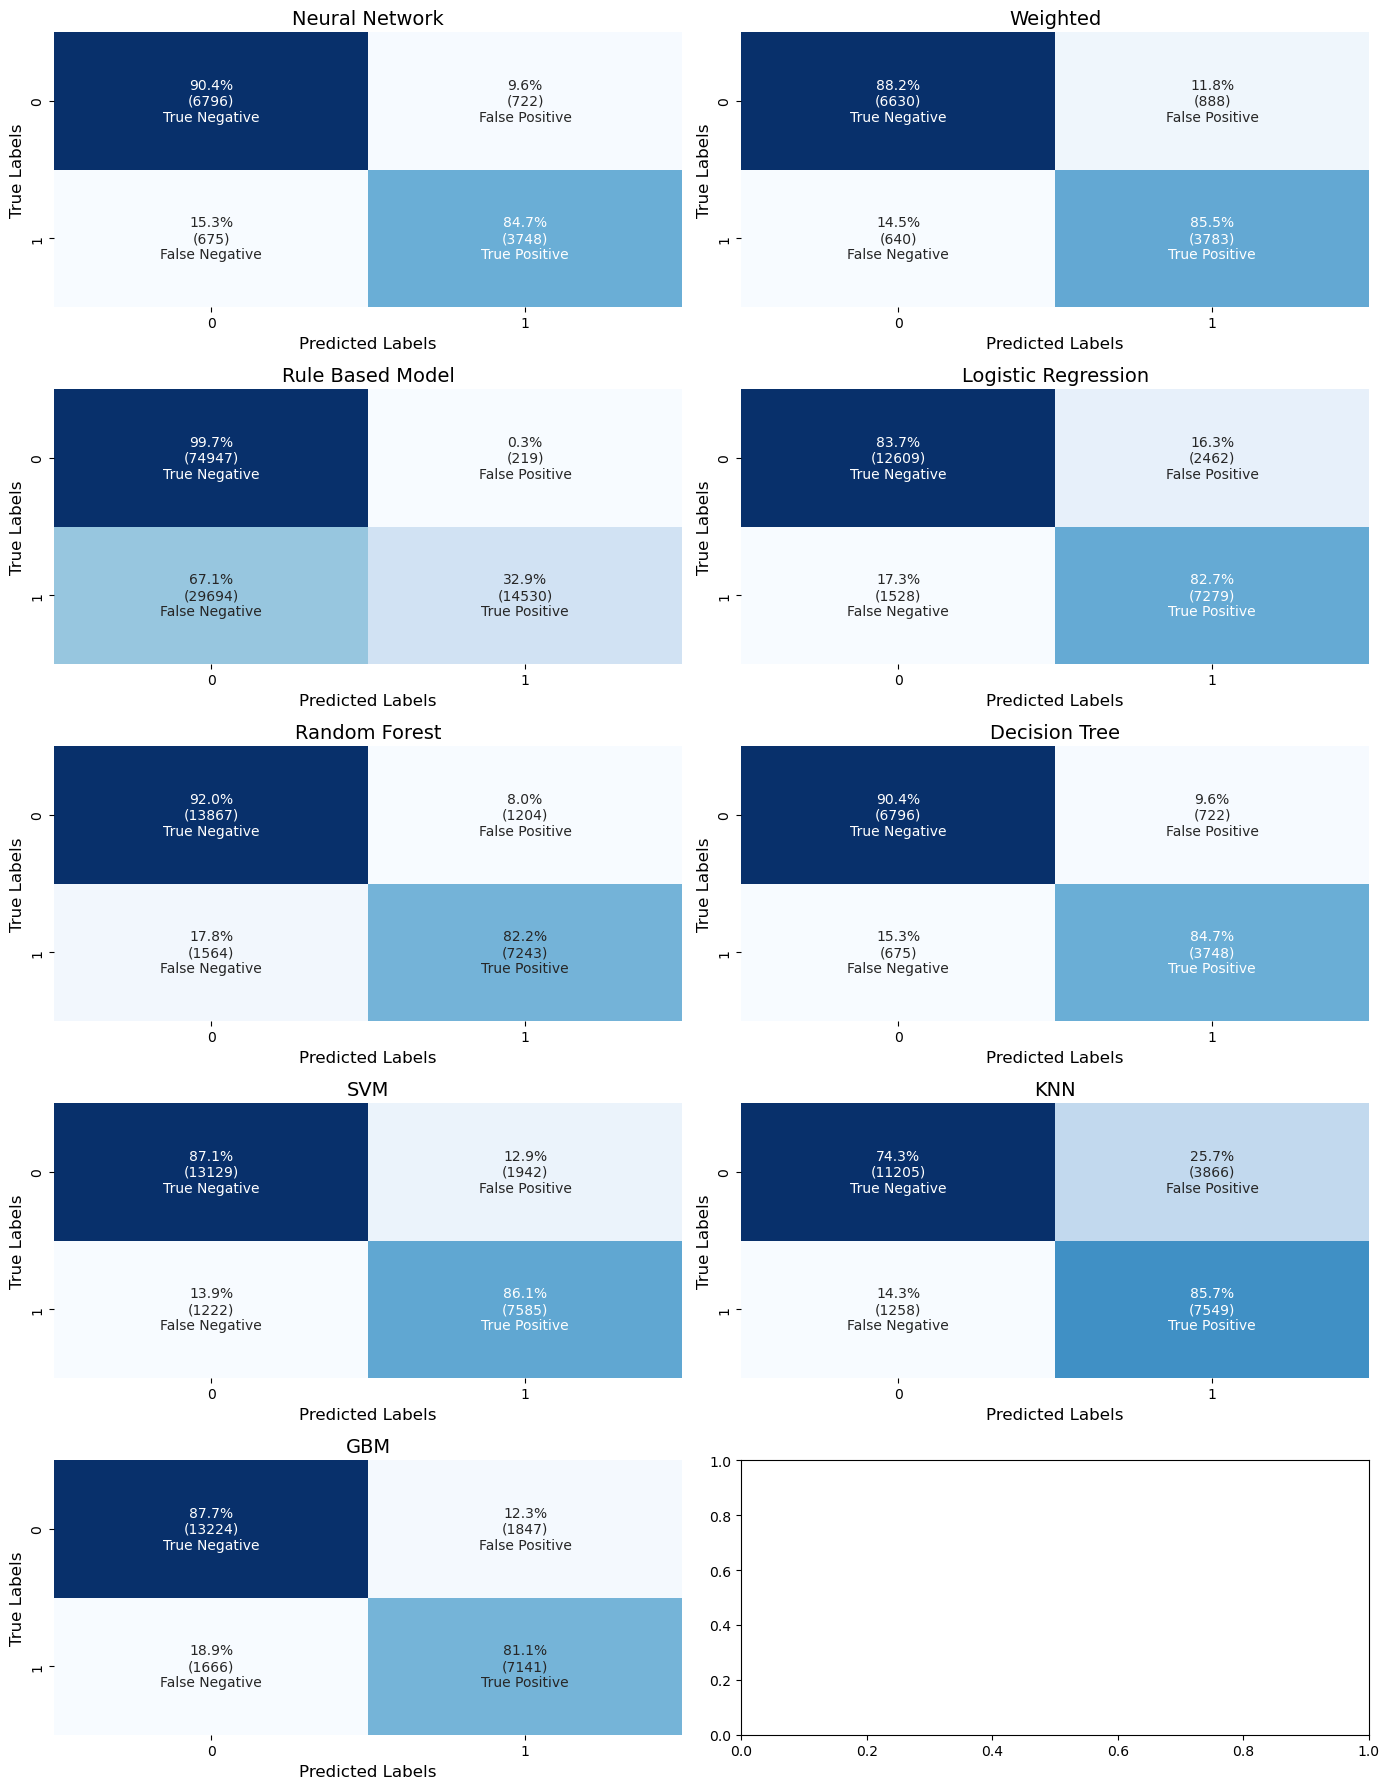

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Defining confusion matrices for each model
confusion_matrices = {
    "Neural Network": np.array([[6796, 722], [675, 3748]]),
    "Weighted": np.array([[6630, 888], [640, 3783]]),
    "Rule Based Model": np.array([[74947, 219], [29694, 14530]]),
    "Logistic Regression": np.array([[12609, 2462], [1528, 7279]]),
    "Random Forest": np.array([[13867, 1204], [1564, 7243]]),
    "Decision Tree": np.array([[6796, 722], [675, 3748]]),
    "SVM": np.array([[13129, 1942], [1222, 7585]]),
    "KNN": np.array([[11205, 3866], [1258, 7549]]),
    "GBM": np.array([[13224, 1847], [1666, 7141]])
}

# Function to calculate the percentage and add descriptive text in each cell of the confusion matrix
def add_description(cm):
    cm_sum = cm.sum(axis=1, keepdims=True)
    cm_percentage = cm / cm_sum.astype(float) * 100
    descriptions = np.array([["True Negative", "False Positive"], ["False Negative", "True Positive"]])
    return np.array([["{0:0.1f}%\n({1})\n{2}".format(percentage, count, description) 
                      for percentage, count, description in zip(row, cm_row, desc_row)] 
                     for row, cm_row, desc_row in zip(cm_percentage, cm, descriptions)])

# Plotting heatmaps with descriptions, counts, and percentages in each cell
fig, axes = plt.subplots(5, 2, figsize=(14, 18))

for ax, (model_name, cm) in zip(axes.flatten(), confusion_matrices.items()):
    cm_description = add_description(cm)
    sns.heatmap(cm, annot=cm_description, fmt='', cmap="Blues", cbar=False, ax=ax)
    ax.set_title(model_name, fontsize=14)
    ax.set_xlabel('Predicted Labels', fontsize=12)
    ax.set_ylabel('True Labels', fontsize=12)

plt.tight_layout()
plt.savefig('confusion_matrices.png')  # Save the figure
plt.show()


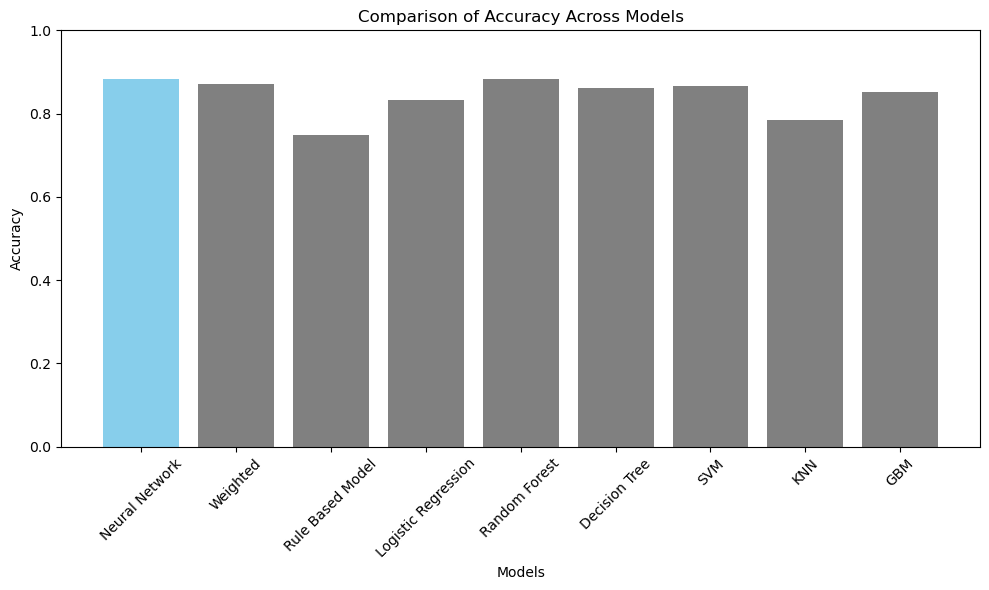

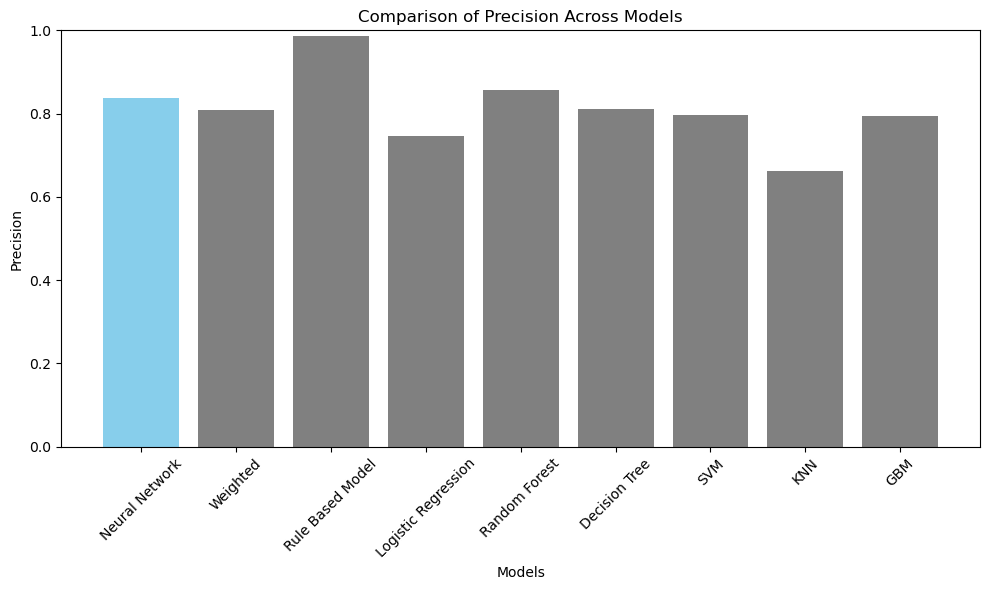

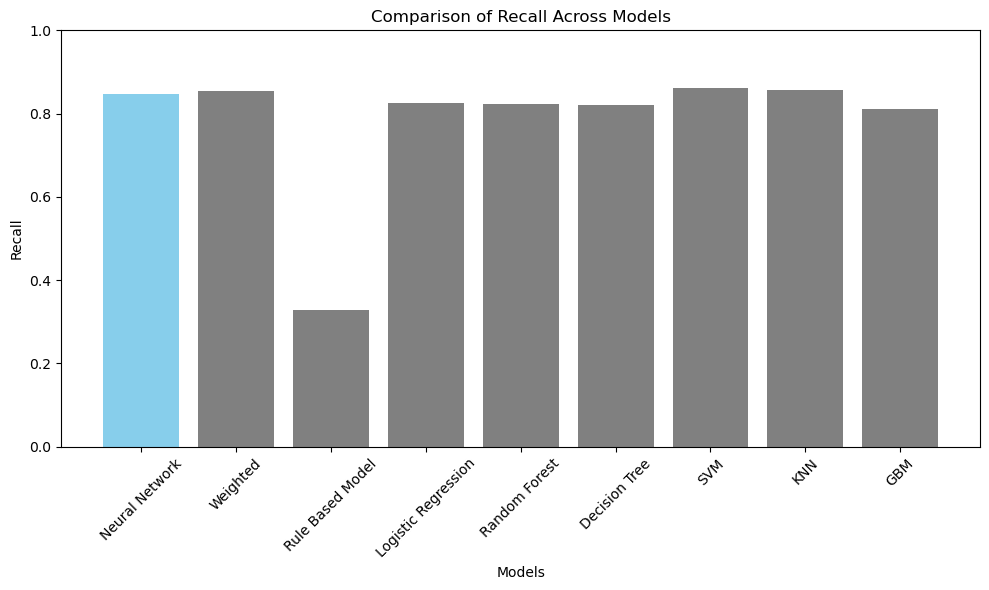

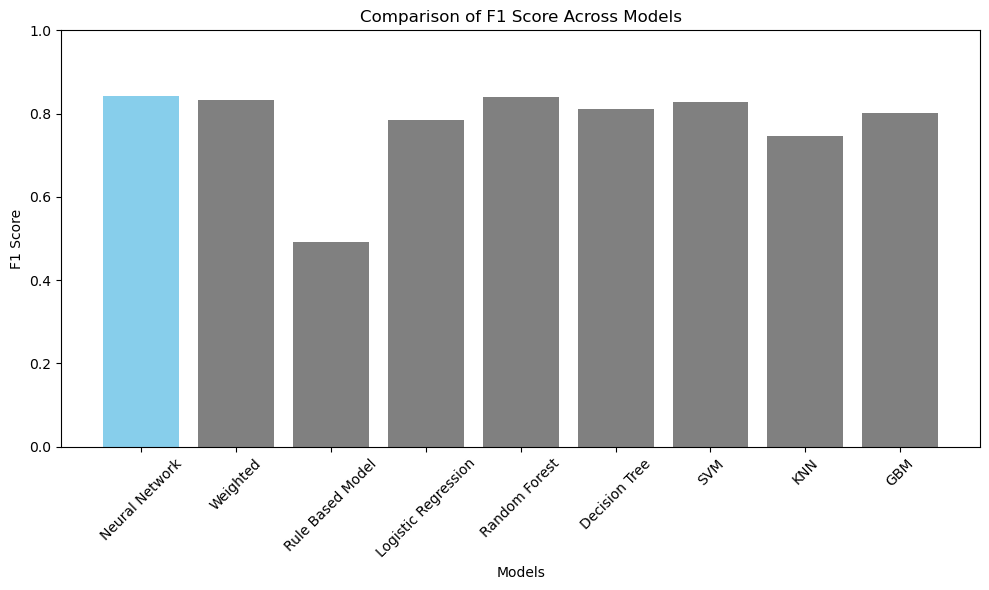

In [11]:
# Redefine the data and models for the custom bar charts
models = ["Neural Network", "Weighted", "Rule Based Model", "Logistic Regression", "Random Forest", "Decision Tree", "SVM", "KNN", "GBM"]
accuracy = [0.8830, 0.8720, 0.7495, 0.8329, 0.8841, 0.8626, 0.8675, 0.7854, 0.8529]
precision = [0.8385, 0.8098, 0.9852, 0.7473, 0.8575, 0.81, 0.7962, 0.6613, 0.7945]
recall = [0.8474, 0.85530, 0.3286, 0.8265, 0.8224, 0.82, 0.8612, 0.8572, 0.8108]
f1_score = [0.8429, 0.8319, 0.4928, 0.7849, 0.8396, 0.81, 0.8274, 0.7466, 0.8026]

# Function to create a bar chart with the specified color for Neural Network and grey for the rest
def create_custom_bar_chart(metric_values, metric_name):
    colors = ['skyblue' if model == 'Neural Network' else 'grey' for model in models]
    plt.figure(figsize=(10, 6))
    plt.bar(models, metric_values, color=colors)
    plt.xlabel('Models')
    plt.ylabel(metric_name)
    plt.title(f'Comparison of {metric_name} Across Models')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig(f'{metric_name}.png')  # Save the figure
    plt.show()

# Create custom bar charts for each metric
create_custom_bar_chart(accuracy, 'Accuracy')
create_custom_bar_chart(precision, 'Precision')
create_custom_bar_chart(recall, 'Recall')
create_custom_bar_chart(f1_score, 'F1 Score')



-  Accuracy: Measures the proportion of correctly classified instances.
-  Precision: Measures the proportion of true positives among the predicted positives.
- Recall: Measures the proportion of true positives among the actual positives.
- F1 Score: Harmonic mean of precision and recall, providing a single measure of model performance.

In [12]:
import torch
import torch.nn as nn
from torchviz import make_dot

# Define the model architecture
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1011, 1024),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.layers(x)

# Instantiate the model
model = NeuralNetwork()

# Create dummy input data
x = torch.randn(1, 1011)

# Forward pass to get the output
y = model(x)

# Create the computational graph
dot = make_dot(y, params=dict(model.named_parameters()))

# Save the graph as a PNG file
dot.format = 'png'
dot.render('neural_network')


'neural_network.png'